##Motiffinding Demonstration
Similar to steps run in pair-matching notebook

import all required libraries

In [0]:
from prov.model import (
    ProvDocument,
    ProvRecord,
    ProvElement,
    ProvEntity,
    ProvActivity,
    ProvAgent,
    ProvRelation,
    PROV_ATTR_ENTITY,
    PROV_ATTR_ACTIVITY,
    PROV_ATTR_AGENT,
    PROV_ATTR_TRIGGER,
    PROV_ATTR_GENERATED_ENTITY,
    PROV_ATTR_USED_ENTITY,
    PROV_ATTR_DELEGATE,
    PROV_ATTR_RESPONSIBLE,
    PROV_ATTR_SPECIFIC_ENTITY,
    PROV_ATTR_GENERAL_ENTITY,
    PROV_ATTR_ALTERNATE1,
    PROV_ATTR_ALTERNATE2,
    PROV_ATTR_COLLECTION,
    PROV_ATTR_INFORMED,
    PROV_ATTR_INFORMANT,
    PROV_ATTR_BUNDLE,
    PROV_ATTR_PLAN,
    PROV_ATTR_ENDER,
    PROV_ATTR_STARTER,
    ProvBundle,
)
INFERRED_ELEMENT_CLASS = {
    PROV_ATTR_ENTITY: ProvEntity,
    PROV_ATTR_ACTIVITY: ProvActivity,
    PROV_ATTR_AGENT: ProvAgent,
    PROV_ATTR_TRIGGER: ProvEntity,
    PROV_ATTR_GENERATED_ENTITY: ProvEntity,
    PROV_ATTR_USED_ENTITY: ProvEntity,
    PROV_ATTR_DELEGATE: ProvAgent,
    PROV_ATTR_RESPONSIBLE: ProvAgent,
    PROV_ATTR_SPECIFIC_ENTITY: ProvEntity,
    PROV_ATTR_GENERAL_ENTITY: ProvEntity,
    PROV_ATTR_ALTERNATE1: ProvEntity,
    PROV_ATTR_ALTERNATE2: ProvEntity,
    PROV_ATTR_COLLECTION: ProvEntity,
    PROV_ATTR_INFORMED: ProvActivity,
    PROV_ATTR_INFORMANT: ProvActivity,
    PROV_ATTR_BUNDLE: ProvBundle,
    PROV_ATTR_PLAN: ProvEntity,
    PROV_ATTR_ENDER: ProvEntity,
    PROV_ATTR_STARTER: ProvEntity,
}

SHORT_NAMES = {
    "prov:Entity": "ent",
    "prov:Activity": "act",
    "prov:Generation": "gen",
    "prov:Usage": "use",
    "prov:Communication": "wifb",
    "prov:Start": "wsb",
    "prov:End": "web",
    "prov:Invalidation": "wib",
    "prov:Derivation": "der",
    "prov:Agent": "agt",
    "prov:Attribution": "wat",
    "prov:Association": "waw",
    "prov:Delegation": "del",
    "prov:Influence": "inf",
    "prov:Alternate": "alt",
    "prov:Specialization": "spe",
    "prov:Mention": "men",
    "prov:Membership": "mem",
}
provClassList = [
    "prov:Entity",
    "prov:Activity",
    "prov:Generation",
    "prov:Usage",
    "prov:Communication",
    "prov:Start",
    "prov:End",
    "prov:Invalidation",
    "prov_Derivation",
    "prov:Agent",
    "prov:Attribution",
    "prov:Association",
    "prov:Delegation",
    "prov:Influence",
    "prov:Alternate",
    "prov:Specialization",
    "prov:Mention",
    "prov:Membership",
]
def download_prov_json_document(url: str) -> ProvDocument:
    # try to download the provided url
    r = requests.get(url)
    
    r.raise_for_status()
    # no exception so far, we have successfuly downloaded it
    prov_doc = ProvDocument.deserialize(content=r.text)
    return prov_doc
document2 = download_prov_json_document("https://openprovenance.org/store/documents/282.json") #larger size file
document = download_prov_json_document("https://openprovenance.org/store/documents/4141.json") #smaller size file

In [0]:
import functools
from pyspark.sql.functions import col, lit, when
from graphframes import *
from pyspark.sql import DataFrame
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from pyspark.sql.functions import col


from itertools import chain
from typing import Dict
import requests
from prov.model import ProvDocument

import json
import os




In [0]:
#Converts PROV document to graphframes
def prov_to_graphframe(prov_document,primitive):
      unified = prov_document.unified()
      node_map = {}
      vList = []
      eList = []
      if primitive:
        for element in unified.get_records(ProvElement):
          vList.append(((str(element)),str(element.identifier),"$".join([SHORT_NAMES[str(element.get_type())],str(element.get_asserted_types())])))
          node_map[element.identifier] = element
      else:
        for element in unified.get_records(ProvElement):
          vList.append(((str(element)),str(element.identifier),SHORT_NAMES[str(element.get_type())]))
          node_map[element.identifier] = element

      for relation in unified.get_records(ProvRelation):
         
              attr_pair_1, attr_pair_2 = relation.formal_attributes[:2]
              
              qn1, qn2 = attr_pair_1[1], attr_pair_2[1]
              if qn1 and qn2:  # only proceed if both ends of the relation exist
                  try:
                      if qn1 not in node_map:
                          node_map[qn1] = INFERRED_ELEMENT_CLASS[attr_pair_1[0]](None, qn1)
                      if qn2 not in node_map:
                          node_map[qn2] = INFERRED_ELEMENT_CLASS[attr_pair_2[0]](None, qn2)
                  except KeyError:
                      continue  # skipping this relation
                  eList.append((str(node_map[qn1].identifier), str(node_map[qn2].identifier),SHORT_NAMES[str(relation.get_type())],SHORT_NAMES[str(node_map[qn2].get_type())]))
      v = sqlContext.createDataFrame(vList,["element","id","type"])
      e = sqlContext.createDataFrame(eList, ["src","dst","relation_type","dst_type"])
      g= GraphFrame(v, e) 
      return g
g=prov_to_graphframe(document,False)
g2 = prov_to_graphframe(document2,False)
gP = prov_to_graphframe(document,True)


verify the creation of graphframes graph

In [0]:
g.vertices.display()

element,id,type
"agent(ex:Germany, [prov:type='prov:Country'])",ex:Germany,agt
"agent(ex:Ferdinand, [s:Fullname=""Archduke Franz Ferdinand"", s:Nationality=""Austro-Hungarian Empire"", prov:type='prov:Person'])",ex:Ferdinand,agt
"agent(ex:Princip, [s:Fullname=""Gavrilo Princip"", s:Nationality=""Serbia"", prov:type='prov:Person'])",ex:Princip,agt
"agent(ex:Serbia, [prov:type='prov:Country'])",ex:Serbia,agt
"agent(ex:AustriaHungary, [prov:type='prov:Country'])",ex:AustriaHungary,agt
"activity(ex:send_message, -, -)",ex:send_message,act
"activity(ex:inspect_annexation, -, -)",ex:inspect_annexation,act
"activity(ex:declares_wars_onTripleEntente, -, -)",ex:declares_wars_onTripleEntente,act
"activity(ex:declares_wars_onSerbia, -, -)",ex:declares_wars_onSerbia,act
"activity(ex:assassinate_Ferdinand, -, -)",ex:assassinate_Ferdinand,act


In [0]:
g.edges.display()

src,dst,relation_type,dst_type
ex:beginning_of_WWI,ex:declares_wars_onTripleEntente,gen,act
ex:Ferdinand,ex:AustriaHungary,del,agt
ex:Princip,ex:Serbia,del,agt
ex:assassinate_Ferdinand,ex:inspect_annexation,wifb,act
ex:send_message,ex:assassinate_Ferdinand,wifb,act
ex:declares_wars_onSerbia,ex:send_message,wifb,act
ex:declares_wars_onTripleEntente,ex:declares_wars_onSerbia,wifb,act
ex:send_message,ex:Germany,waw,agt
ex:assassinate_Ferdinand,ex:Ferdinand,waw,agt
ex:send_message,ex:AustriaHungary,waw,agt


run a simple motif finding query

In [0]:
motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);!(b)-[]->(a);!(c)-[]->(b)").filter("a.id != c.id")
motif.display()

a,e1,b,e2,c
"List(activity(ex:send_message, -, -), ex:send_message, act)","List(ex:send_message, ex:assassinate_Ferdinand, wifb, act)","List(activity(ex:assassinate_Ferdinand, -, -), ex:assassinate_Ferdinand, act)","List(ex:assassinate_Ferdinand, ex:inspect_annexation, wifb, act)","List(activity(ex:inspect_annexation, -, -), ex:inspect_annexation, act)"
"List(entity(ex:beginning_of_WWI, [s:year=""1914""]), ex:beginning_of_WWI, ent)","List(ex:beginning_of_WWI, ex:declares_wars_onTripleEntente, gen, act)","List(activity(ex:declares_wars_onTripleEntente, -, -), ex:declares_wars_onTripleEntente, act)","List(ex:declares_wars_onTripleEntente, ex:declares_wars_onSerbia, wifb, act)","List(activity(ex:declares_wars_onSerbia, -, -), ex:declares_wars_onSerbia, act)"
"List(activity(ex:declares_wars_onTripleEntente, -, -), ex:declares_wars_onTripleEntente, act)","List(ex:declares_wars_onTripleEntente, ex:support_from_germany, use, ent)","List(entity(ex:support_from_germany), ex:support_from_germany, ent)","List(ex:support_from_germany, ex:TripleAllianceAgreement, der, ent)","List(entity(ex:TripleAllianceAgreement, [s:year=""1882""]), ex:TripleAllianceAgreement, ent)"
"List(activity(ex:declares_wars_onSerbia, -, -), ex:declares_wars_onSerbia, act)","List(ex:declares_wars_onSerbia, ex:send_message, wifb, act)","List(activity(ex:send_message, -, -), ex:send_message, act)","List(ex:send_message, ex:assassinate_Ferdinand, wifb, act)","List(activity(ex:assassinate_Ferdinand, -, -), ex:assassinate_Ferdinand, act)"
"List(entity(ex:beginning_of_WWI, [s:year=""1914""]), ex:beginning_of_WWI, ent)","List(ex:beginning_of_WWI, ex:declares_wars_onTripleEntente, gen, act)","List(activity(ex:declares_wars_onTripleEntente, -, -), ex:declares_wars_onTripleEntente, act)","List(ex:declares_wars_onTripleEntente, ex:support_from_germany, use, ent)","List(entity(ex:support_from_germany), ex:support_from_germany, ent)"
"List(activity(ex:declares_wars_onSerbia, -, -), ex:declares_wars_onSerbia, act)","List(ex:declares_wars_onSerbia, ex:send_message, wifb, act)","List(activity(ex:send_message, -, -), ex:send_message, act)","List(ex:send_message, ex:Germany, waw, agt)","List(agent(ex:Germany, [prov:type='prov:Country']), ex:Germany, agt)"
"List(activity(ex:declares_wars_onTripleEntente, -, -), ex:declares_wars_onTripleEntente, act)","List(ex:declares_wars_onTripleEntente, ex:support_from_germany, use, ent)","List(entity(ex:support_from_germany), ex:support_from_germany, ent)","List(ex:support_from_germany, ex:Germany, wat, agt)","List(agent(ex:Germany, [prov:type='prov:Country']), ex:Germany, agt)"
"List(activity(ex:send_message, -, -), ex:send_message, act)","List(ex:send_message, ex:assassinate_Ferdinand, wifb, act)","List(activity(ex:assassinate_Ferdinand, -, -), ex:assassinate_Ferdinand, act)","List(ex:assassinate_Ferdinand, ex:Ferdinand, waw, agt)","List(agent(ex:Ferdinand, [s:Fullname=""Archduke Franz Ferdinand"", s:Nationality=""Austro-Hungarian Empire"", prov:type='prov:Person']), ex:Ferdinand, agt)"
"List(activity(ex:assassinate_Ferdinand, -, -), ex:assassinate_Ferdinand, act)","List(ex:assassinate_Ferdinand, ex:Ferdinand, waw, agt)","List(agent(ex:Ferdinand, [s:Fullname=""Archduke Franz Ferdinand"", s:Nationality=""Austro-Hungarian Empire"", prov:type='prov:Person']), ex:Ferdinand, agt)","List(ex:Ferdinand, ex:AustriaHungary, del, agt)","List(agent(ex:AustriaHungary, [prov:type='prov:Country']), ex:AustriaHungary, agt)"
"List(activity(ex:declares_wars_onTripleEntente, -, -), ex:declares_wars_onTripleEntente, act)","List(ex:declares_wars_onTripleEntente, ex:declares_wars_onSerbia, wifb, act)","List(activity(ex:declares_wars_onSerbia, -, -), ex:declares_wars_onSerbia, act)","List(ex:declares_wars_onSerbia, ex:send_message, wifb, act)","List(activity(ex:send_message, -, -), ex:send_message, act)"


create a few utilities functions for the type-counting function

In [0]:
def formatter(typeDict,lvl):
  for key,value in typeDict.items():
    fullType = []
    for i in range(lvl+1):
      variety = []
      for v in value:
        if v[i] not in variety:
          variety.append(v[i])
      
      fullType.append("[" + "|".join(variety) + "]")
    typeDict[key] = "→".join(fullType)
  return typeDict
def typeZero(g):
  typeList = [x["type"]for x in g.vertices.rdd.collect()]
  return typeList
def typeOne(g):
  motif = g.find("(a)-[e1]->(b);!(b)-[]->(a)")
  edgesList = [[x["e1"],x["a"]]for x in motif.rdd.collect()]
  typeDict = dict((e[1].id,[]) for e in edgesList)
  for e in edgesList:
    zeroType=g.vertices.filter(col("id")==e[0].dst)
    generic = [x["type"]for x in zeroType.rdd.collect()][0]
    fullType = [e[0].relation_type,generic]
    temp = typeDict[e[1].id]
    temp.append(fullType)
    typeDict[e[1].id] = temp
  return typeDict
def typeTwo(g):
  motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);!(b)-[]->(a);!(c)-[]->(b)").filter("a.id != c.id")
  edgesList = [[x["e1"],x["e2"],x["a"]]for x in motif.rdd.collect()]
  typeDict = dict((e[2].id,[]) for e in edgesList)
  for e in edgesList:
    zeroType=g.vertices.filter(col("id")==e[1].dst)
    generic = [x["type"]for x in zeroType.rdd.collect()][0]
    fullType = [e[0].relation_type,e[1].relation_type,generic]
    temp = typeDict[e[2].id]
    temp.append(fullType)
    typeDict[e[2].id] = temp
  return typeDict
def typeThree(g):
  motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c)")
  edgesList = [[x["e1"],x["e2"],x["e3"],x["a"]]for x in motif.rdd.collect()]
  typeDict = dict((e[3].id,[]) for e in edgesList)
  for e in edgesList:
    zeroType=g.vertices.filter(col("id")==e[2].dst)
    generic = [x["type"]for x in zeroType.rdd.collect()][0]
    fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,generic]
    temp = typeDict[e[3].id]
    temp.append(fullType)
    typeDict[e[3].id] = temp
  return typeDict
def typeFour(g):
  motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d)")
  edgesList = [[x["e1"],x["e2"],x["e3"],x["e4"],x["a"]]for x in motif.rdd.collect()]
  typeDict = dict((e[4].id,[]) for e in edgesList)
  for e in edgesList:
    zeroType=g.vertices.filter(col("id")==e[3].dst)
    generic = [x["type"]for x in zeroType.rdd.collect()][0]
    fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,e[3].relation_type,generic]
    temp = typeDict[e[4].id]
    temp.append(fullType)
    typeDict[e[4].id] = temp
  return typeDict
def typeFive(g):
  motif = g.find("(a)-[e1]->(b); (b)-[e2]->(c);(c)-[e3]->(d);(d)-[e4]->(E);(E)-[e5]->(f);!(b)-[]->(a);!(c)-[]->(b);!(d)-[]->(c);!(E)-[]->(d);!(f)-[]->(E)")
  edgesList = [[x["e1"],x["e2"],x["e3"],x["e4"],x["e5"],x["a"]]for x in motif.rdd.collect()]
  typeDict = dict((e[5].id,[]) for e in edgesList)
  for e in edgesList:
    zeroType=g.vertices.filter(col("id")==e[4].dst)
    generic = [x["type"]for x in zeroType.rdd.collect()][0]
    fullType = [e[0].relation_type,e[1].relation_type,e[2].relation_type,e[3].relation_type,e[4].relation_type,generic]
    temp = typeDict[e[5].id]
    temp.append(fullType)
    typeDict[e[5].id] = temp
  return typeDict

verify the function with a 2-type count

In [0]:
formatter(typeTwo(g),2)

Out[9]: {'ex:declares_wars_onSerbia': '[wifb]→[waw|wifb]→[agt|act]',
 'ex:declares_wars_onTripleEntente': '[use|wifb]→[wat|wifb|der]→[agt|act|ent]',
 'ex:send_message': '[wifb]→[waw|wifb]→[agt|act]',
 'ex:beginning_of_WWI': '[gen]→[use|wifb]→[ent|act]',
 'ex:assassinate_Ferdinand': '[waw]→[del]→[agt]'}

In [0]:
#select a type-counting function according to the given level, level <5 only
def functionSelecter(i,g):
  if i==0:
    return typeZero(g)
  elif i==1:
    return list(formatter(typeOne(g),1).values())
  elif i==2:
    return list(formatter(typeTwo(g),2).values())
  elif i==3:
    return list(formatter(typeThree(g),3).values())
  elif i==4:
    return list(formatter(typeFour(g),4).values())
  elif i==5:
    return list(formatter(typeFive(g),5).values())
  else:
    print("error")
    
#generate feature vector that summarize the data with each prov types' occurence
def generateFeatVec(g,lvl):
  if lvl>5:
    print("cannot be above 5 levels for default training")
  else:
    
    featVecDict = {}
    for i in range(lvl+1):
      typesList = functionSelecter(i,g)
      for fpt in typesList:
        featVecDict[str(fpt)] = typesList.count(fpt)
    return featVecDict


##Benchmarking

chekcing the size of declared sample graphs

In [0]:
len(generateFeatVec(g,2))

Out[11]: 14

In [0]:
len(generateFeatVec(g2,2))

Out[12]: 24

plot of benchmarking of motif finding saved!

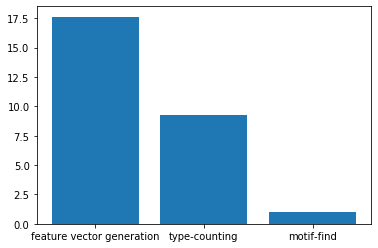

In [0]:
import time
import matplotlib.pyplot as plt
def M_TypeCount(document,h):
    return functionSelecter(h,prov_to_graphframe(document, False))
def M_genFV(document,h):
    return generateFeatVec(prov_to_graphframe(document, False),h)
def benchmarkingM(document):
    fv = [] #feature vector generation runtime results
    tcp = [] #type counting processes runtime results
    tc = [] #type counting(finding a motif) runtime results
    # loop 5 times and find average value
    for i in range(5):
        start = time.perf_counter()
        M_genFV(document,2)
        end = time.perf_counter()
        fv.append(end - start)

        start = time.perf_counter()
        M_TypeCount(document, 2)
        end = time.perf_counter()
        tcp.append(end - start)

        start = time.perf_counter()
        g = prov_to_graphframe(document,False)
        g.find("(a)-[e1]->(b); (b)-[e2]->(c);!(b)-[]->(a);!(c)-[]->(b)").filter("a.id != c.id")
        end = time.perf_counter()
        tc.append(end - start)
    fvtime = sum(fv) / len(fv)
    tcptime = sum(tcp) / len(tcp)
    tctime = sum(tc) / len(tc)
    plt.bar(["feature vector generation","type-counting", "motif-find"],
            [fvtime / tctime, tcptime / tctime, tctime / tctime])
    print("plot of benchmarking of motif finding saved!")
benchmarkingM(document)

Generate the sparse matrices

In [0]:
def formatFileName(f):
  f= f.replace(".json","")
  f=f.replace(".","_")
  f=f.replace("-","_")
  f = f+".json"
  return f
def csv_procs(f,path):
  csv_data = path + "/" +"graphs.csv"
  df = pd.read_csv(csv_data)
  csv_data = dict(zip(list(df.graph_file), list(df.label)))
  return csv_data[f]
def createSparseMtxSparkMotifFinding(filenames,path,lvl,primitive):
    csv_data = path + "/" +"graphs.csv"
    df = pd.read_csv(csv_data)
    df['graph_file'] = df['graph_file'].apply(lambda x: formatFileName(x))
    csv_dict = dict(zip(list(df.graph_file), list(df.label)))
    
    prov_list = [(ProvDocument.deserialize(path+"/"+f),csv_dict[f])for f in filenames]
    featVecsList = []
    for doc in prov_list:
      featVecs = generateFeatVec(prov_to_graphframe(doc[0],primitive),lvl) 
      featVecs["label"] = doc[1]
      featVecsList.append(featVecs)
      
    
    df = sc.parallelize(featVecsList).toDF()
    return df

Write each sparse matrices into orc files

In [0]:
def generateOrcFile(path,lvl,primitive):
  filenames=os.listdir(path)
  jsonfilenames = [f for f in filenames if f.endswith(".json")]
  X=createSparseMtxSparkMotifFinding(jsonfilenames,path,lvl,primitive)
  X = X.na.fill(value=0)
  return X

In [0]:
mainpath = "/dbfs/FileStore/shared_uploads/jian.1.huang@kcl.ac.uk/provSpark-datasets"

dirList = {"/CM-Routes",
            "/CM-RouteSets",
            "/CM-Buildings",
            "/PG-D",
            "/PG-T"
            }
for path in dirList:
  X_primitive = generateOrcFile(mainpath+path,2,True)

  X_primitive.write.format("orc").save(mainpath+path+"P"+".orc")
  
  X_not_primitive = generateOrcFile(mainpath+path,2,False)

  X_not_primitive.write.format("orc").save(mainpath+path+"NP"+".orc")
  

Run below cell if you want to save your results as csv files

In [0]:
for dataset in dataset_proper_names:
  sample = spark.read.orc(mainpath+"/"+dataset+".orc")
  sample.toPandas().to_csv(mainpath+"/generatedData/"+dataset+".csv")